# Importación de librerías

In [12]:
import pandas as pd
import numpy as np

import os
import librosa
import librosa.display

import matplotlib.pyplot as plt
import seaborn as sns


In [37]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Lectura del dataset

In [21]:
urbansound8k_path = "../../data/raw/UrbanSound8K/"

# Primer dataset - Carpeta con los audios
urbansound8k_audio_path = "audio/"

# Segundo dataset - Archivo CSV con metadatos sobre los audios
urbansound8k_metadata_path_file = "metadata/UrbanSound8K.csv"

# Dataset CSV con metadatos generados a partir de los audios
dataset_urbansound8k_vfinal_path_file = "../../data/final/dataset_urbansound8k_vfinal.csv"

variable_predict =  'classID'

dataset_urbansound8k_df = pd.read_csv(dataset_urbansound8k_vfinal_path_file, sep=";")

dataset_urbansound8k_df.head(3)

,classID,tasa_cruce_cero,entropia_espectograma,avg_centroide_espectral,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13
0,3,1947,6.716659,2503.702337,-275.91843,119.49280,-98.21178,-66.515140,-42.606050,0.505066,-28.330938,-5.746867,9.992785,4.795411,15.461894,-0.069880,-2.842674
1,2,27607,9.991457,2339.221804,-500.90840,185.10641,-86.53282,49.858850,9.230822,22.548956,-3.567175,12.220052,7.720082,-6.460391,16.995657,-6.625116,1.469779
2,2,20971,9.728703,2070.826863,-531.19530,186.93994,-70.34916,40.429245,9.121047,18.398588,6.283282,15.504061,9.613501,-7.113610,16.179823,-5.710522,-0.899251


In [15]:
dataset_urbansound8k_df.columns

Index(['classID', 'tasa_cruce_cero', 'entropia_espectograma',
       'avg_centroide_espectral', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4',
       'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11',
       'mfcc_12', 'mfcc_13'],
      dtype='object')

In [23]:
# Separar las características y la variable objetivo
columnas_caracteristicas = ['tasa_cruce_cero', 'entropia_espectograma', 'avg_centroide_espectral',
             'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7',
             'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13']
columnas_caracteristicas = ['mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7',
             'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13']


X = dataset_urbansound8k_df[columnas_caracteristicas]  # Características
y = dataset_urbansound8k_df['classID']  # Variable objetivo

#  Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dataset_train_df = dataset_urbansound8k_df[columnas_caracteristicas + [variable_predict]].copy()



# Modelos de Clasificacion

## > KNeighborsClassifier

In [34]:


scaler = MinMaxScaler()

def determinar_best_model_knn(train_knn, variable_predict, flag_normalizar=0):
  
  print(" KNN evaluación con cross validation")
  print(" --------- ")
  print(f" Variable a predecir : {variable_predict} ")
  if flag_normalizar == 1:
    print(" Datos a normalizar : activado ")
  
  cv = KFold(n_splits = 11, shuffle=True, random_state=42) # Configurar el KFold
  plt.figure(figsize=(8, 5))  
  
  for i, weights in enumerate(['uniform', 'distance']):
    total_scores = []

    for n_neighbors in range(1,30):
      fold_accuracy = []
      knn = KNeighborsClassifier(n_neighbors, weights=weights)
      
      # Verificar cada uno de los modelos con validación cruzada.
      for train_fold, test_fold in cv.split(train_knn):
                    
        # División train test aleatoria
        f_train = train_knn.loc[train_fold]
        f_test = train_knn.loc[test_fold]

        # Condicion para normalizar los datos
        if flag_normalizar == 1:
          norm_f_train_df = scaler.fit_transform(f_train.drop([variable_predict], axis=1))
          norm_f_test_df = scaler.fit_transform(f_test.drop([variable_predict], axis=1))
        else:
          norm_f_train_df = f_train.drop([variable_predict], axis=1)
          norm_f_test_df = f_test.drop([variable_predict], axis=1)

        # Entrenamiento y ejecución del modelo
        knn.fit( X = norm_f_train_df, y = f_train[variable_predict])
        y_pred = knn.predict(X = norm_f_test_df)

        # Evaluación del modelo
        acc = accuracy_score(f_test[variable_predict], y_pred)
        fold_accuracy.append(acc)

      # Calculo promedio de la accuracy
      total_scores.append(sum(fold_accuracy)/len(fold_accuracy))  

    plt.plot(range(1,len(total_scores)+1), total_scores, marker='o', label=weights)
    print ('Max Value ' +  weights + " : " +  str(max(total_scores)) +" (" + str(np.argmax(total_scores) + 1) + ")")
    plt.ylabel('ACC') 

  plt.grid()
  plt.legend()
  plt.show()

 KNN evaluación con cross validation
 --------- 
 Variable a predecir : classID 
Max Value uniform : 0.9024240614652309 (1)
Max Value distance : 0.9024240614652309 (1)


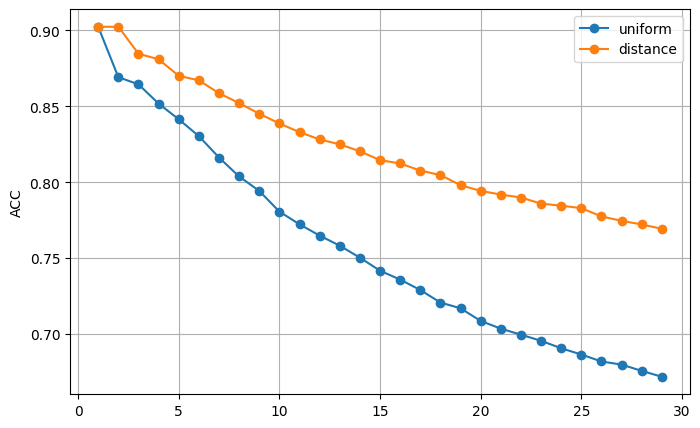

In [35]:
determinar_best_model_knn(dataset_train_df, variable_predict, flag_normalizar=0)

Accuracy: 0.8912421293646251
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94       203
           1       0.81      0.74      0.78        86
           2       0.85      0.90      0.88       183
           3       0.90      0.88      0.89       201
           4       0.92      0.86      0.89       206
           5       0.91      0.96      0.93       193
           6       0.70      0.82      0.76        72
           7       0.93      0.94      0.93       208
           8       0.92      0.95      0.93       165
           9       0.86      0.83      0.84       230

    accuracy                           0.89      1747
   macro avg       0.88      0.88      0.88      1747
weighted avg       0.89      0.89      0.89      1747



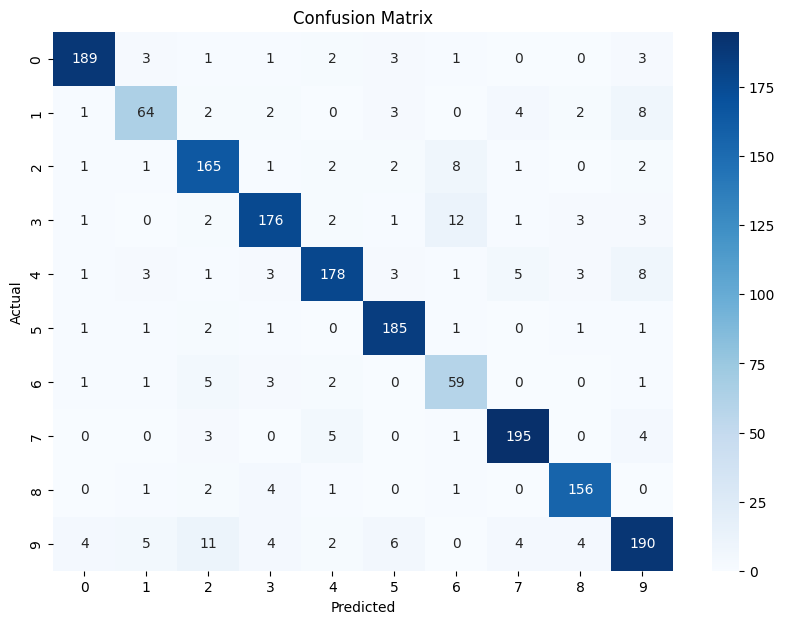

In [40]:
# Crear el modelo KNN
knn = KNeighborsClassifier(n_neighbors=2, weights='distance')

# Entrenar el modelo
knn.fit(X_train, y_train)

# Realizar predicciones
y_pred = knn.predict(X_test)

# Evaluar el modelo
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

# Mostrar la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=knn.classes_, yticklabels=knn.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

